---
title: "Brain MRI Detection with Interpretability"
description: "Use of vision transformer, training them, and adding interpretability to the classification problem"
date: 2025-08-25
categories: [vit, medical-imaging, attention_rollout, grad-cam]
---

### Contents

1. [Introduction](#introduction)
2. [Dataset Exploration](#dataset)
3. [Vision Transformer](#vit)
4. [CLS-Attention](#cls-attention)
5. [Attention Rollout](#attention-rollout)
6. [GradCAM](#grad-cam)
7. [Conclusion](#conclusion)
8. [References](#references)

### 1. Introduction{#introduction}

Artificial intelligence, particularly deep learning, has shown incredible promise in medical imaging. Models can now analyze scans like MRIs with an accuracy that rivals human experts. But these models are often **black boxes**. They give us an answer, but they don't tell us how they reached it.

For a doctor to trust an AI's diagnosis, they need to see the evidence. This is where model interpretability becomes crucial.

In this post, we'll walk through a complete project to not only train a Vision Transformer (ViT) to classify brain tumors from MRI scans but also to use powerful visualization techniques to see exactly what the model is "looking at" when it makes a prediction.

### 2. Dataset Exploration{#dataset}

The dataset used is available easily in Kaggle, named: **brain-tumor-mri-dataset**. This dataset consists of about 7000 images of Brain MRIs, which contains images for three types of tumors (glioma, meningioma, and pituitary) as well as images of healthy brains (no tumor). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os 

# naming of folders for train and test dataset
train, test = 'train', 'test'

# downloading the data and exploring the types of labels
base_directory = "dataset" 
categories = os.listdir(base_directory+ "/"+ train)
print(f'Categories are: {", ".join(categories)}')

Categories are: pituitary, notumor, meningioma, glioma


Let's see the images of each classes to get a hang of the dataset. 

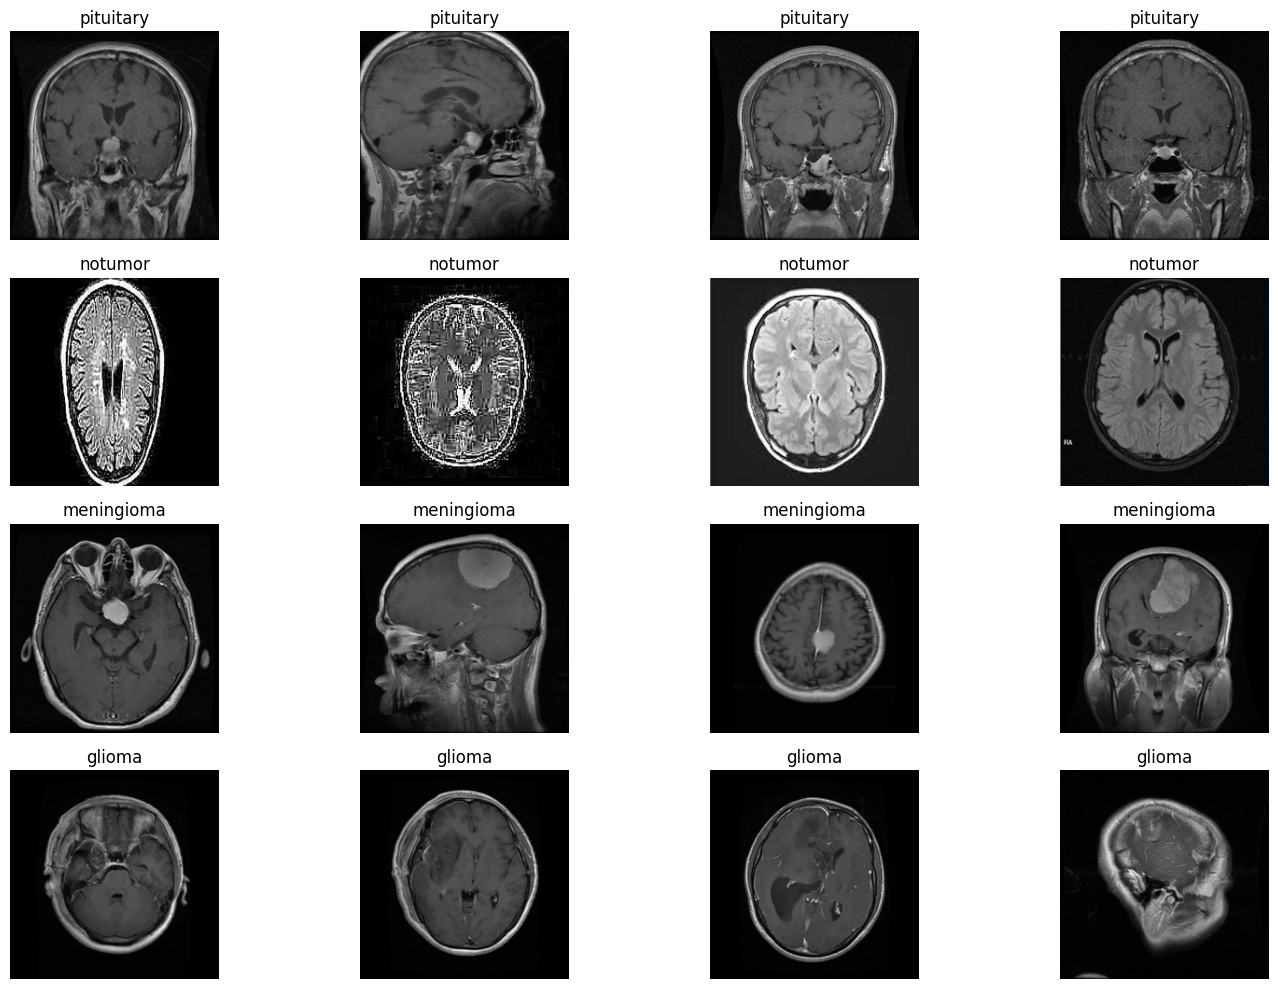

In [3]:
import matplotlib.pyplot as plt 
import random 
from PIL import Image


def display_images(dataset_type, num_images=4, image_size=(224, 224)):
    dataset_path = os.path.join(base_directory, dataset_type)
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images
        
        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                # sampling any random files of each category 
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()
    
display_images('train', num_images=4)

Here, we can see 4 different classes, with 3 types of tumor and 1 no tumor. The objective of the deep learning models will have to be predict the correct class of any image passed. We have trained a vision transformer for classifying the brain-mri images.

### 3. Vision Transformer{#vit}

In [4]:
from torchvision import models
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load a pre-trained Vision Transformer
model = models.vit_b_16(pretrained=False)
print(model) 

Using device: cuda
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=Tr

For this experiment, we used the vit_b_16 model. A key part of this procedure was implementing a robust **data augmentation** pipeline for the training set. This artificially expands the dataset and makes the model more resilient by teaching it to recognize tumors even if the images are:

- Flipped horizontally (RandomHorizontalFlip)
- Slightly shifted (RandomAffine)
- Varied in brightness (ColorJitter)
- Rotated a bit (RandomRotation)

The training hyperparameters were as follows:

- Model: vit_b_16(pretrained=False)
- Optimizer: Adam with a learning rate of 1e-4.
- Loss Function: CrossEntropyLoss.
- Learning Rate Scheduler: StepLR, which reduces the learning rate by a set factor (gamma=0.5) every few epochs (step_size=5).
- Batch Size: 64

With these hyperparameters, VIT model was trained for about 100 epochs. However, the best perfomed model was obtained at epoch 32, after which the validation accuracy didn't improve for about 10 more epochs. Thus, with the early stopping logic, the training stopped. 

The metrics of the saved model was: \
`Train Loss: 0.2863 Acc: 0.8857 | Val Loss: 0.3044 Acc: 0.8750`

<img src="vit_loss.png" width="600"/> <img src="vit_accuracy.png" width="600"/>

When inferred with the test_dataset, the accuracy obtained was 89% with the confusion matrix as follows: 

![](vit_confusion_matrix.png)

Our model achieved high accuracy, but we still need to know why it works. We'll use two powerful techniques to create heatmaps that highlight the most important regions in the MRI scan for a given prediction.

1. [CLS] Token Attention: The Vision Transformer uses a special `[CLS]` token to aggregate information from the entire image to make a final decision. By visualizing this token's attention, we can see which parts of the image it focused on. We will look at this attention for every layer to see how its focus evolves.

2. Grad-CAM: It uses the model's internal gradients to create a heatmap that answers the question: "Which pixels provided the most evidence for the 'glioma' prediction?"

Let us initialize the dataloaders, and select a test image for visualization.

cuda
Length of test dataset: 655
Length of val dataset: 656
Using device: cuda

Successfully loaded model weights.

Displaying input image #0 which was predicted as: glioma


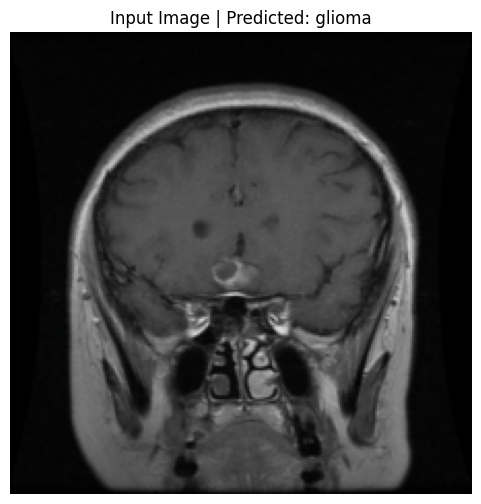

In [1]:
import utils 
from transformers import ViTForImageClassification, ViTConfig
import torch 
import numpy as np
import matplotlib.pyplot as plt 
import cv2 


IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES_SIDE = IMAGE_SIZE // PATCH_SIZE

test_dataset, test_loader, _, _, data_vars = utils.read_data(data_mode='test', batch_size=4)
categories = data_vars['categories']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# only getting the architecture
config = ViTConfig.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(categories),
    output_attentions=True,
    image_size=IMAGE_SIZE
)

model = ViTForImageClassification(config)
model = model.to(device)

# best_model.pt is the saved model 
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()
print("\nSuccessfully loaded model weights.")

test_img, test_label = next(iter(test_loader))
test_img_tensor = test_img.to(device)

outputs = model(test_img_tensor, output_attentions=True)
all_layer_attentions = outputs.attentions
logits = outputs.logits
predicted_class_indices = torch.argmax(logits, dim=-1)


# taking one single image for analysis
image_index = 0
image_to_analyze_b1 = test_img_tensor[image_index:image_index+1]
predicted_class_idx = predicted_class_indices[image_index].item()
predicted_label = categories[predicted_class_idx]

original_img_tensor = test_img_tensor[image_index]
img_np = original_img_tensor.cpu().numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)


print(f"\nDisplaying input image #{image_index} which was predicted as: {predicted_label}")
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title(f"Input Image | Predicted: {predicted_label}")
plt.axis('off')
plt.show()

In [6]:
def plot_heatmap_on_ax(ax, img_np, heatmap, title):
    """Helper function to plot a heatmap overlay on an image axis."""
    heatmap_grid = heatmap.reshape(NUM_PATCHES_SIDE, NUM_PATCHES_SIDE)
    heatmap_resized = cv2.resize(heatmap_grid.cpu().detach().numpy(), (IMAGE_SIZE, IMAGE_SIZE))
    ax.imshow(img_np)
    ax.imshow(heatmap_resized, cmap='viridis', alpha=0.5)
    ax.set_title(title)
    ax.axis('off')

### 4. CLS-Attention{#cls-attention} 

In a Vision Transformer, the CLS token is the representation used for classification. To understand why the model made a prediction, we want to see what the CLS token is looking at in the image. CLS attention evolves from global to object-focused across layers. Hence, we will try to visualize it across all layers to see which area of the image contributed more to the classification done by out VIT model.


Generating Grid Visualization: Layer-wise [CLS] Attention


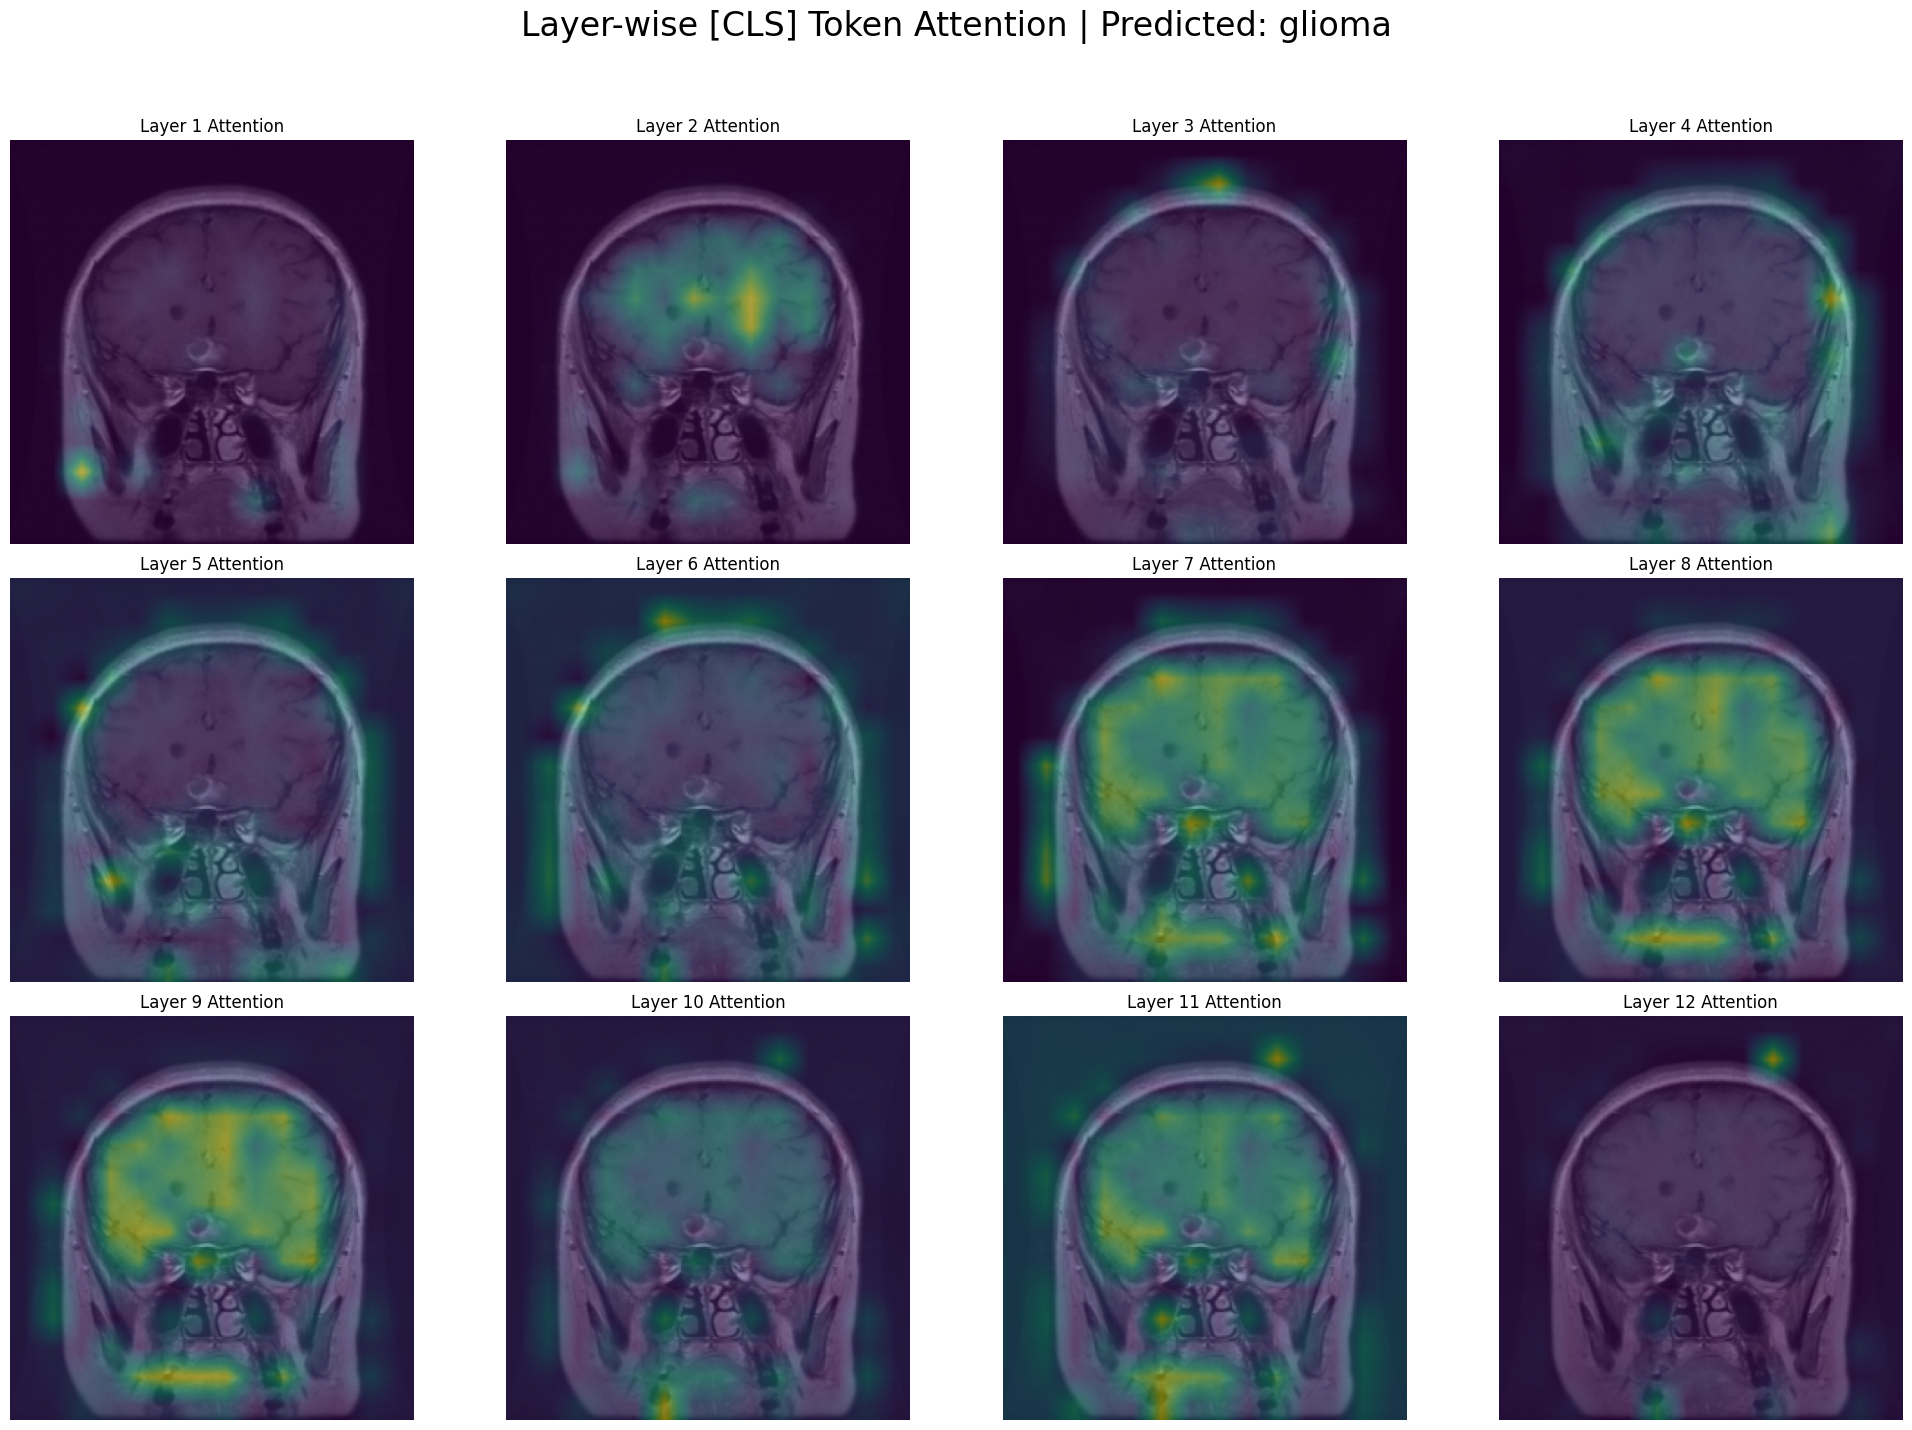

In [ ]:
def visualize_layerwise_cls_attention(all_layer_attentions, img_np, predicted_label):    
    print("\nGenerating Grid Visualization: Layer-wise [CLS] Attention")
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f"Layer-wise [CLS] Token Attention | Predicted: {predicted_label}", fontsize=24)
    axs = axs.flatten()

    for i in range(12):
        layer_attention = all_layer_attentions[i]
        cls_attention_map = torch.mean(layer_attention, dim=1)[0, 0, 1:] # Avg heads, get CLS row
        plot_heatmap_on_ax(axs[i], img_np, cls_attention_map, f"Layer {i+1} Attention")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

image_attentions_cls_tuple = tuple(att[image_index:image_index+1] for att in all_layer_attentions)
visualize_layerwise_cls_attention(image_attentions_cls_tuple, img_np, predicted_label)

In the early layers, the model acts like a low-level feature detector.

- Layer 1: The attention is highly localized on a small, distinct feature on the left side of the brain. The model isn't seeing a "tumor" yet; it's seeing a "bright spot," an "edge," or an interesting "texture."

- Layers 2-4: The attention starts to diffuse slightly, picking up on other interesting low-level features across the brain. It's still gathering basic visual evidence without a high-level understanding.

- Layer 5 & 6: The attention starts to group the initial features, becoming less about individual spots and more about regions.

- Layer 7 & 8: The attention becomes much broader. The model is no longer just looking at the tumor itself but is now paying attention to the entire upper region of the brain. It seems to have learned that the features of a glioma exist within a larger anatomical context.

- Layers 9 & 10: The attention is now very broad and confident, covering the entire pathological area. The model has concluded that this whole upper region of the brain is relevant to the "glioma" classification. This is a sign of a sophisticated model—it's not just finding a single point of evidence but recognizing a widespread pattern.

- Layers 11 & 12: The attention remains broad, representing the final, aggregated evidence from all previous layers. This holistic view is what feeds into the classification head to make the final prediction of "glioma."

### 5. Attention Rollout {#attention-rollout}

A Vision Transformer (ViT) is composed of multiple layers of self-attention. While it's tempting to just look at the final layer's attention map to see what the model is focusing on, this can be misleading. The final layer's attention is applied to embeddings that are already a complex mixture of the initial embeddings from all previous layers.

Attention Rollout is a technique proposed by Abnar & Zuidema (2020) to better approximate the full attention flow through the network. It aggregates the attention matrices from all layers to create a single map that shows how much each input token contributes to the output tokens.



### Steps

1. Start with the first layer’s attention

	`all_layer_attentions[0]` contains the attention weights for the first transformer layer `(shape: [batch, heads, tokens, tokens])`. `torch.mean(..., dim=1)` averages across all the attention heads, so we get one attention map per layer instead of per head. This becomes our initial rollout.

2. We iterate through the remaining layers
	- For each layer, we average over the heads (torch.mean).
	- Add an identity matrix to the attention map. This makes sure that each token can always "attend to itself" (preserving direct connections).
	- We multiply `(torch.matmul)` the current layer’s attention with the accumulated rollout. This composes the attentions across layers, so we capture how attention paths stack together as we move deeper in the network.
	- We extract how the CLS token looks at the image patches
	After processing all layers, rollout contains the cumulative influence of each token on every other token.

3. `rollout[:, 0, 1:]` selects:
	- Row 0 → corresponds to the CLS token.
	- Columns 1: → corresponds to the patch tokens (ignoring CLS itself).
	This gives us the final **attention rollout** map showing which image patches the CLS token (used for classification) is attending to, across the whole network.


Generating Visualization: Attention Rollout:


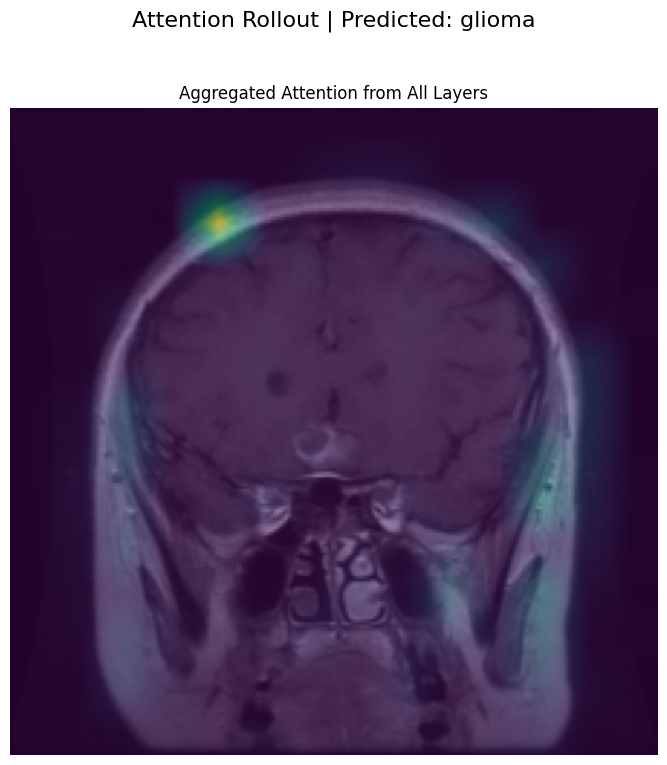

In [8]:
def calculate_attention_rollout(all_layer_attentions):
    """
	Computes attention rollout across all layers 
    """
    # 1: Start with the first layer's attention
    # Average across attention heads → one attention map per layer
    # Shape: [batch, tokens, tokens]
    rollout = torch.mean(all_layer_attentions[0], dim=1)

    # 2: Iterate through the remaining layers
    for i in range(1, len(all_layer_attentions)):
        # average attention heads for this layer
        attn_map = torch.mean(all_layer_attentions[i], dim=1)

        # identity matrix 
        identity = torch.eye(attn_map.shape[-1], device=attn_map.device)
        attn_map = attn_map + identity

        # Multiply with accumulated rollout to stack attention paths
        rollout = torch.matmul(attn_map, rollout)

    # 3: Extract CLS → patch token attention
    # CLS token is at index 0, patches are from index 1 onwards
    # Shape: [batch, tokens-1]
    cls_rollout = rollout[:, 0, 1:]
    return cls_rollout


def visualize_attention_rollout(all_layer_attentions, img_np, predicted_label):
    """
    Calculates and visualizes the combined Attention Rollout map.
    """
    print("\nGenerating Visualization: Attention Rollout:")
    
    # rollout map from the function
    rollout_map = calculate_attention_rollout(all_layer_attentions)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fig.suptitle(f"Attention Rollout | Predicted: {predicted_label}", fontsize=16)
    plot_heatmap_on_ax(ax, img_np, rollout_map.squeeze(), "Aggregated Attention from All Layers")    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

image_attentions_tuple = tuple(att[image_index:image_index+1] for att in all_layer_attentions)
visualize_attention_rollout(image_attentions_tuple, img_np, predicted_label)

### 6. Grad-CAM{#grad-cam}

Gradient-weighted Class Activation Mapping (Grad-CAM) is a powerful technique for interpretation. It uses the gradients of the final prediction to highlight the evidence in the image.

To implement this, we need to grab internal data from the model during a forward and backward pass. The cleanest way to do this in PyTorch is with hooks. A hook is like a listener device we can attach to a model layer to inspect the data flowing through it without permanently changing the model's code. The captured gradients tell us the importance of each feature channel in our target layer. We average these gradients to get a single importance weight per channel. \
We compute a weighted average of the activations, using the weights we just calculated. The `torch.einsum` function is a highly efficient way to do this. This weighted sum is our heatmap. We apply a ReLU function to ensure we only see the features that had a positive contribution to the final decision.

We implement this for visualizing all layers' gradients and activations, so as to see the different areas each layer focused while processing the image.


Generating Grid Visualization: Layer-wise Grad-CAM


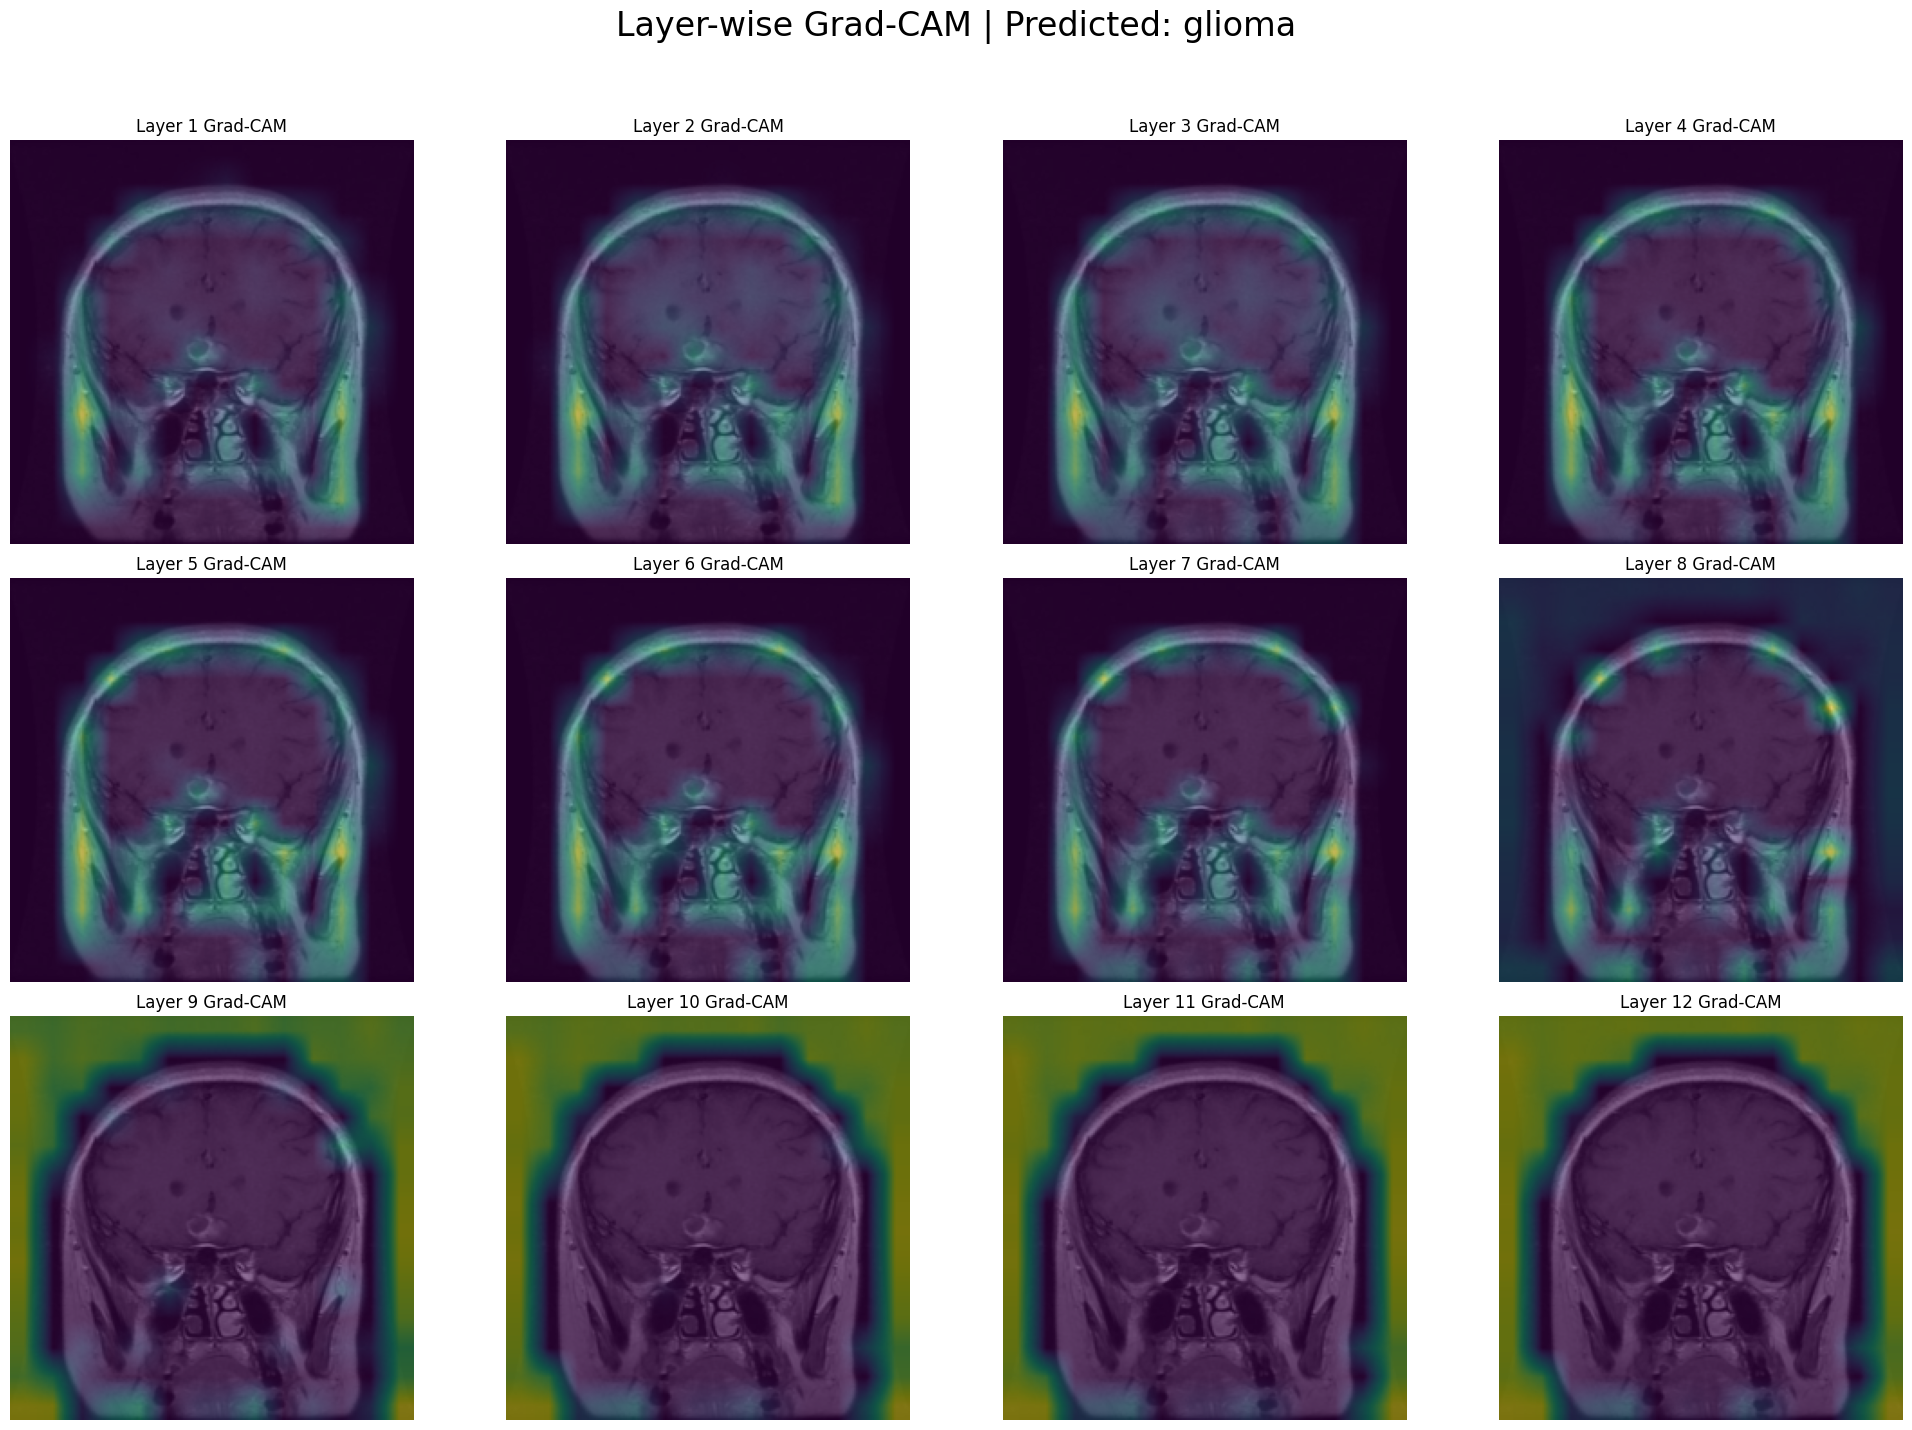

In [ ]:
class ViTGradCAM:
    """A class to generate Grad-CAM heatmaps for a Vision Transformer model."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def _register_hooks(self):
        # adding hooks
        self.forward_handle = self.target_layer.register_forward_hook(self._capture_activations)
        self.backward_handle = self.target_layer.register_full_backward_hook(self._capture_gradients)

    def remove_hooks(self):
        self.forward_handle.remove()
        self.backward_handle.remove()

    def __call__(self, input_tensor, class_idx):
        self.model.zero_grad()
        logits = self.model(input_tensor).logits
        target_score = logits[:, class_idx].sum()
        target_score.backward(retain_graph=True)
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=1)
        cam = torch.einsum('bpd,bd->bp', activations, weights)
        
		# applying relu
        cam = torch.relu(cam)
        return cam[:, 1:]


def visualize_layerwise_grad_cam(model, image_to_analyze_b1, img_np, predicted_class_idx, predicted_label):
    print("\nGenerating Grid Visualization: Layer-wise Grad-CAM")
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f"Layer-wise Grad-CAM | Predicted: {predicted_label}", fontsize=24)
    axs = axs.flatten()

	# visualizing the gradients for all layers in VIT
    for i in range(12):
        try:
            target_layer = model.vit.encoder.layer[i].output
            grad_cam = ViTGradCAM(model, target_layer=target_layer)
            cam_map = grad_cam(image_to_analyze_b1, class_idx=predicted_class_idx).squeeze()
            
			# removing hooks so it won't affect further tasks
            grad_cam.remove_hooks()
            plot_heatmap_on_ax(axs[i], img_np, cam_map, f"Layer {i+1} Grad-CAM")
        except Exception as e:
            print(f"Could not generate Grad-CAM for layer {i+1}: {e}")
            axs[i].set_title(f"Layer {i+1} Grad-CAM (Error)")
            axs[i].axis('off')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_layerwise_grad_cam(model, image_to_analyze_b1, img_np, predicted_class_idx, predicted_label)

Unlike attention maps which show focus, Grad-CAM shows the importance for the final prediction at each layer. The early layers act like a basic feature extractor, searching for simple patterns like edges, textures, and gradients. The heatmaps are sparse and tend to highlight the outer edges of the head and skull rather than the brain tissue itself. The heatmaps in mid layers[5-8] move inward, and by Layers 7 and 8, a clear, focused hotspot appears directly over the location of the tumor in the upper left of the brain. In the last 4 layers, the focused hotspot from the middle layers disappears, and the heatmaps become extremely broad and diffuse, eventually covering the entire brain and surrounding area. It depicts that the tumor is present in the image, showcasing the entire figure of the image as evidence.

### 7. Conclusion{#conclusion}

In this post, we've gone from a dataset of MRI scans to a fully trained Vision Transformer capable of accurately classifying brain tumors. But more importantly, we've denied to accept the model as a "black box." Through layer-wise attention and Grad-CAM visualizations, we've demonstrated that our model is behaving logically. We witnessed its focus evolve from simple textures and edges in the early layers to complex, semantic concepts in the later ones.

While techniques like Grad-CAM and Attention Rollout provide powerful insights, they are still approximations of a highly complex internal process. They may not perfectly capture the model's complete reasoning, but they serve a crucial purpose of building confidence. They show us that the model is not relying on random artifacts in the image but is learning relevant, medically significant patterns.

### 8. References{#references}

- [AN IMAGE IS WORTH 16X16 WORDS](https://arxiv.org/pdf/2010.11929)
- [Quantifying Attention Flow in Transformers](https://arxiv.org/pdf/2005.00928)
- [Brain Tumor Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- [GradCAM](https://arxiv.org/pdf/1610.02391) 